<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-preprocessed-data-and-testing-df" data-toc-modified-id="Import-preprocessed-data-and-testing-df-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import preprocessed data and testing df</a></span></li><li><span><a href="#Join-datasets-and-clean-pcr-column" data-toc-modified-id="Join-datasets-and-clean-pcr-column-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Join datasets and clean pcr column</a></span></li><li><span><a href="#State-repartition-of-cases" data-toc-modified-id="State-repartition-of-cases-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>State repartition of cases</a></span></li><li><span><a href="#Studying-age-and-Case-prevalence" data-toc-modified-id="Studying-age-and-Case-prevalence-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Studying age and Case prevalence</a></span><ul class="toc-item"><li><span><a href="#There-seems-to-be-a-link-between-age-and-numbers-of-PCR-positive-cases" data-toc-modified-id="There-seems-to-be-a-link-between-age-and-numbers-of-PCR-positive-cases-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>There seems to be a link between age and numbers of PCR positive cases</a></span></li></ul></li></ul></div>

# Import preprocessed data and testing df 

In [70]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import sys
sys.path.append('../scripts')
from detect_duplicates import df as df_patient
import seaborn as sns
import matplotlib.pyplot as plt

engine = create_engine('sqlite:///../data/data.db', echo=False)
con = engine.connect()
df_test = pd.read_sql('select * from test', con=con)
con.close()

# Join datasets and clean pcr column

In [63]:
df = pd.merge(df_patient,df_test, on='patient_id')
df.pcr = df.pcr.str.replace(r'Negative|N', '0', regex=True)
df.pcr = df.pcr.str.replace(r'Positive|P', '1',regex=True)
df.pcr = df.pcr.astype('int')

# State repartition of cases

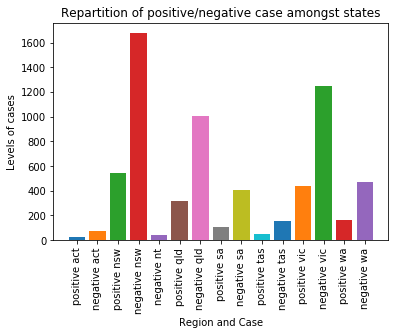

In [120]:
gb = df.groupby(['state', 'pcr']).count().dropna().reset_index()
gb = gb[['state', 'pcr', 'patient_id']]
gb = gb[gb.patient_id > 5]

for state in gb.state.unique():
    try:
        neg, pos = gb[gb.state==state]['patient_id'].values
        plt.bar("positive " + state, pos)
    except ValueError:
        neg = gb[gb.state==state]['patient_id'].values
    plt.bar("negative " + state, neg)
plt.xticks(rotation=90)
plt.title('Repartition of positive/negative case amongst states')
plt.xlabel('Region and Case')
plt.ylabel('Levels of cases')
plt.show()

# Studying age and Case prevalence

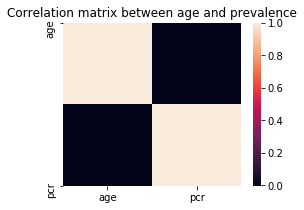

In [139]:
df = df.dropna(subset=['age'])
plt.figure(figsize=(4,3))
sns.heatmap(df[['age', 'pcr']].corr())
plt.title('Correlation matrix between age and prevalence')
plt.show()

In [170]:
quantiles = np.linspace(0, 1, 5).tolist()[1:]
sep_df = []
for idx, q in enumerate(quantiles):
    if idx > 0:
        sep_df.append(df[df.age.between(quantiles[idx-1], df.age.quantile(q))])
    else:
        sep_df.append(df[df.age < df.age.quantile(q)])

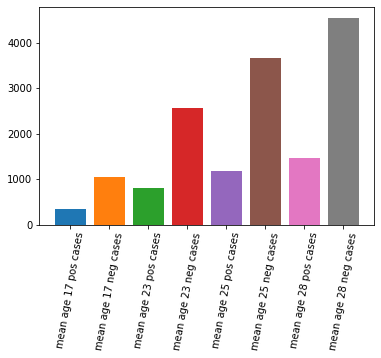

In [186]:
for ix, df in enumerate(sep_df):
    plt.bar(f"mean age {df.age.mean():.0f} pos cases", df.pcr.sum())
    plt.bar(f"mean age {df.age.mean():.0f} neg cases", df.shape[0] - df.pcr.sum())
plt.xticks(rotation=80)
plt.show()

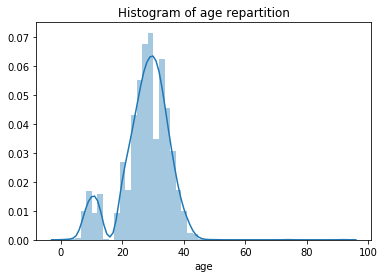

In [223]:
sns.distplot(df.sort_values('age').age)
plt.title('Histogram of age repartition')
plt.show()

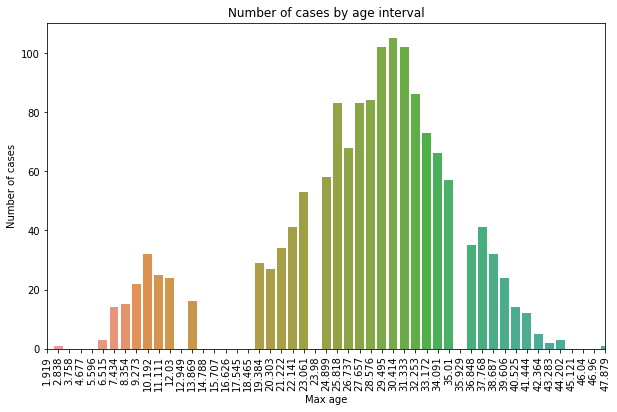

In [257]:
pcr_age = df.groupby(pd.cut(df.age, np.linspace(df.age.min(), df.age.max(), 100))).sum()
plt.figure(figsize=(10,6))
sns.barplot(pcr_age.index.map(lambda s: s.right).values, pcr_age.pcr.values)
plt.xticks(rotation=90)
plt.xlim(0, 50)
plt.xlabel('Max age')
plt.ylabel('Number of cases')
plt.title('Number of cases by age interval')
plt.show()

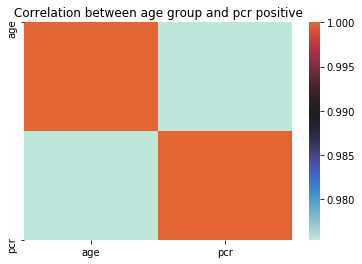

In [267]:
sns.heatmap(pcr_age[['age', 'pcr']].corr(), center=0.99)
plt.title('Correlation between age group and pcr positive')
plt.show()

## There seems to be a link between age and numbers of PCR positive cases

this relationship might come from the fact that age distribution as pcr cases.